In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import pandas as pd
from simulation import run_simulation
from datetime import timedelta

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import networkx as nx
import random
import metis
from collections import defaultdict
from datetime import timedelta, datetime
from tqdm import tqdm

from rwc import controversy_score
from util import tw_list, get_cut_ratio, add_edges, remove_edges
from leopard import update_partition

DEBUG = False


# prevent pickling error in multiprocessing
def defaultdict_using_list_func():
    return defaultdict(list)


def earlist_date_func():
    return datetime(1970, 1, 1)

In [5]:
retweets = pd.read_pickle('data/july.pkl')
text = pd.read_pickle('data/july_text.pkl')

In [ ]:
incremental = True
update_interval = timedelta(minutes=10)
T_window = timedelta(minutes=6*60)
top_node_percent=0.01

result = run_simulation(retweets,
                        T_window=T_window,
                        head_n=5*1e5,
                        incremental=True,
                        update_interval=update_interval,
                        top_node_percent=top_node_percent,
                        top_k_computation_interval=timedelta(minutes=20))

116517it [00:52, 2361.07it/s]

In [15]:
top_k_log = result[1]
tags = list(set([i['tag'] for l in top_k_log for i in l['list']]))
print(tags)

['VeranoMTV2016', 'ALDUBIYAMBukasNa', 'MGWV']


In [23]:
from util import build_graph_from_df
t = tags[1]
retweets_subset = retweets.head(int(1e5))
sub_df = retweets_subset[retweets_subset['hashtag'] == t]


g = build_graph_from_df(sub_df)
pr = nx.pagerank(g)
cuts, cluster_ids = metis.part_graph(g, 2)


partition = defaultdict(list)
for n, c in zip(g.nodes(), cluster_ids):
    partition[c].append(n)

topk0 = sorted(partition[0], key=lambda k: pr[k], reverse=True)[:5]
topk1 = sorted(partition[1], key=lambda k: pr[k], reverse=True)[:5]
print(topk0)
print(topk1)

def all_tweets_ids_by_users(df, users):
    tweets = []
    ids = set()
    for u in users:
        ids |= set(df[(df['retweetee'] == u) | (df['retweeter'] == u)]['message_id'].as_matrix().tolist())
    return ids
        
top_user_tweets_0 = all_tweets_ids_by_users(sub_df, topk0)
top_user_tweets_1 = all_tweets_ids_by_users(sub_df, topk1)

[3515025553, 3309489938, 3403014073, 711215151433785344, 4311833712]
[1127926933, 2466499093, 4848161419, 3313366232, 3853825394]


In [25]:
text0 = text.loc[top_user_tweets_0]['body'].tolist()
text1 = text.loc[top_user_tweets_1]['body'].tolist()

In [26]:
text0, text1 = map(set, [text0, text1])

In [27]:
for t in random.sample(text0, 5):
    print('-'*10)
    print(t)


----------
RT @OFCALDubKoTo: EXCERPTS FROM THIS YEAR'S 100 MOST BEAUTIFUL STARS - MAINE &amp; ALDEN BEING ON TOP. RT &amp; SPREAD GV! #ALDUBIYAMBukasNa https:…
----------
RT @ALDENophileCLUB: Alden bakod level 10000: 

"You can look, you can drool but let's make it clear... She's mine."

#ALDUBIYAMBukasNa👊🏻 h…
----------
RT @AlDubBigBoyz: Never above you
Never below you
Always beside you
@aldenrichards02 @mainedcm

©papixure_ne
#ALDUBIYAMBukasNa M https://t.…
----------
RT @ALDENophileCLUB: "If this is not territorial, I don't know what it is."

In between legs, hand on hand, hands on lap and arm on lap 😅🔥…
----------
RT @AlDubBigBoyz: U can discover more about a person in an hour of play thn in a year of conversation
©papixure_ne
#ALDUBIYAMBukasNa M http…


In [28]:
for t in random.sample(text1, 5):
    print('-'*10)
    print(t)


----------
RT @AlDubBigGirlz: Good morning 👋😙 
Happy Tuesday everyJuan😄
Have a great &amp; fantastic day coz #ALDUBIYAMBukasNa po yan😄 kakaexcite💞 
 🍒 htt…
----------
RT @MAINEnatics_OFC: CUTIES! 😊 

@mainedcm | © papixure_ne 

#ALDUBIYAMBukasNa https://t.co/ZrMvYvpsr4
----------
RT @ImBossingVic: ALDUB ARGUE: WHAT COULD BE THE POSSIBLE CAUSE

CLICK HERE https://t.co/opbYQzSaTl

#ALDUBIYAMBukasNa
----------
RT @ImBossingVic: VIRAL: LOLA NIDORA'S WORDS ARE LIKE A DOUBLE EDGED SWORD

CLICK HERE
https://t.co/I5nK5A6UV5

#ALDUBIYAMBukasNa
----------
RT @ImBossingVic: BECAUSE OF ALDUB THE PHILIPPINE ENTERTAINMENT INDUSTRY IS HAVING A FACELIFT #ALDUBIYAMBukasNa


In [29]:
from rwc import controversy_score
rwc, _ = controversy_score(g, node2cluster=dict(zip(g.nodes(), cluster_ids)), top_percent=0.01)

100%|██████████| 100/100 [00:02<00:00, 33.02it/s]


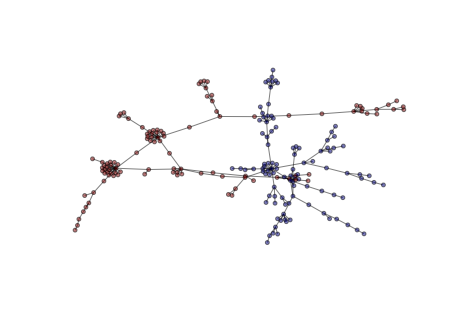

In [30]:
from forceatlas import forceatlas2_layout
from util import get_largest_connected_subgraph

g = get_largest_connected_subgraph(g)
_, cluster_ids = metis.part_graph(g, 2)
pos = forceatlas2_layout(g, iterations=100)
fig = nx.draw(g, pos=pos, with_label=False, node_color=cluster_ids, node_size=15, alpha=0.5)